In [3]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'fastscnn_hyperparameters_tuning__refactoring'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'deep-seasonal-color-analysis-system'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (575/575), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 1094 (delta 302), reused 456 (delta 274), pack-reused 519
Receiving objects: 100% (1094/1094), 270.74 MiB | 25.85 MiB/s, done.
Resolving deltas: 100% (621/621), done.
/content/deep-seasonal-color-analysis-system
Updating files: 100% (249/249), done.
Branch 'main__fastscnn_hyperparameters_tuning' set up to track remote branch 'main__fastscnn_hyperparameters_tuning' from 'origin'.
Switched to a new branch 'main__fastscnn_hyperparameters_tuning'
From https://githu

In [4]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.cloud.UNet import unet
from metrics_and_losses import metrics
from utils import segmentation_labels, utils, custom_transforms
import matplotlib.pyplot as plt
from palette_classification import color_processing
from models import config

try:
  executing_on_colab
except NameError:
  executing_on_colab = False
  weights_path = config.WEIGHTS_PATH
  dataset_path = config.DATASET_PATH

In [6]:
# === defining transforms ===

tH, tW = 256, 256
bilateral_filter = custom_transforms.BilateralFilter(sigma_color=50, sigma_space=100, diameter=7)

image_transform = T.Compose([
    T.Resize((tH, tW)), 
    bilateral_filter,
    T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])

target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
_, X_test, _, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
test_dataset = dataset.MyDataset(X_test, Y_test, image_transform, target_transform)

batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
# loading tuned model
model_name = 'unet_ccncsa_tuned'
model = unet.UNet(out_channels=n_classes)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
test_score_fn = metrics.batch_IoU
label_names = list(segmentation_labels.labels.keys())
class_weights = torch.tensor(config.CLASS_WEIGHTS, device=device)
batch_IoU = training_and_testing.test_model(device, model, test_dataset, batch_size, test_score_fn)
batch_IoU_with_labels = {label: score for label, score in list(zip(label_names, batch_IoU.tolist()))}
batch_mIoU = batch_IoU.mean().item()
batch_weighted_mIoU = utils.tensor_weighted_average(batch_IoU, class_weights).item()
for label in batch_IoU_with_labels:
    print(f'batch_IoU_{label}: {batch_IoU_with_labels[label]}')
print(f'batch_mIoU={batch_mIoU}')
print(f'batch_weighted_mIoU={batch_weighted_mIoU}')

Device: cuda.

Inference completed in around 64 seconds.
batch_IoU_background: 0.9618738293647766
batch_IoU_lips: 0.647980809211731
batch_IoU_eyes: 0.558042049407959
batch_IoU_nose: 0.79366534948349
batch_IoU_skin: 0.8847730159759521
batch_IoU_hair: 0.8041813373565674
batch_IoU_eyebrows: 0.5543178915977478
batch_IoU_ears: 0.7271596789360046
batch_IoU_teeth: 0.7752918601036072
batch_IoU_beard: 0.598564624786377
batch_IoU_sunglasses: 0.8383647799491882
batch_mIoU=0.7403831481933594
batch_weighted_mIoU=0.7227123975753784


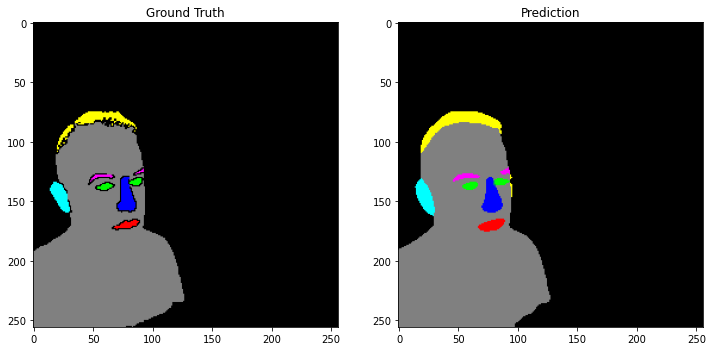

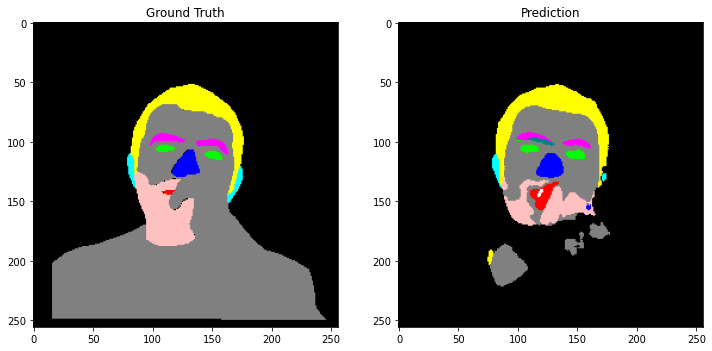

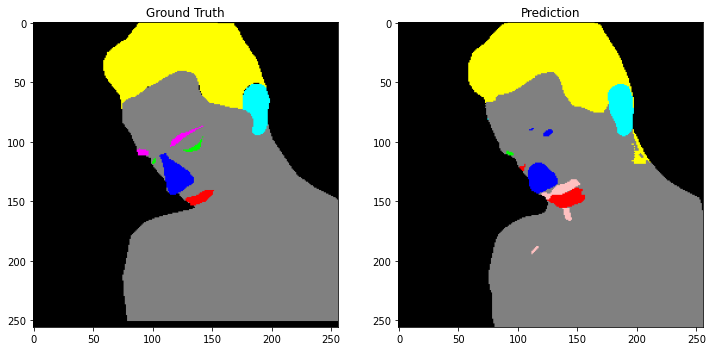

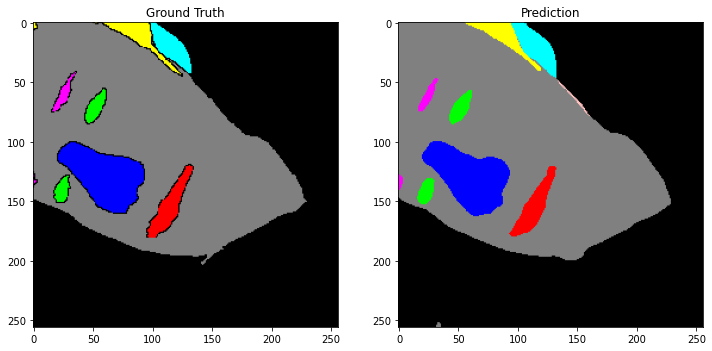

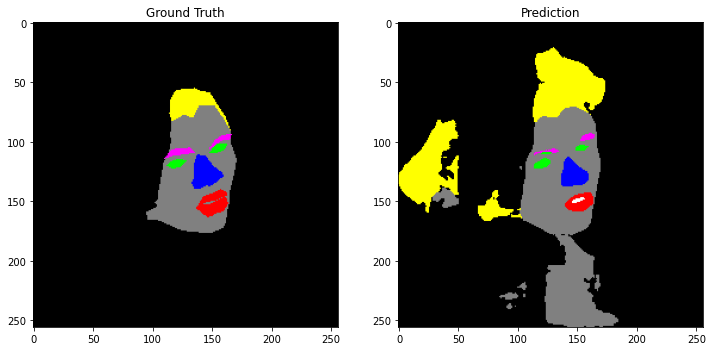

In [8]:
# plotting some examples from test dataset
utils.plot_random_examples(device, model, test_dataset, n_examples=5)